In [ ]:
tr = pd.read_csv(INPUT_DIR + 'train_transaction.csv')
te = pd.read_csv(INPUT_DIR + 'test_transaction.csv')
trid = pd.read_csv(INPUT_DIR + 'train_identity.csv')
teid = pd.read_csv(INPUT_DIR + 'test_identity.csv')

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore")

COLS_TO_SHOW = 150

def h(content): # Function for displaying content in HTML/Markdown format
    display(HTML(content)) # display content in HTML/Markdown format

def timehist1(col): # Function for displaying time histogram
    N = 8000 if col in ['TransactionAmt'] else 9999999999999999 # Clip transaction amount for better view
    tr[tr['isFraud'] == 0].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    tr[tr['isFraud'] == 1].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    te.set_index('TransactionDT')[col].clip(0, N).plot(style='.', title=col + ' values over time (blue=no-fraud, orange=fraud, green=test)', figsize=(15, 3))
    plt.show()
    
def _desc(data, col, label):
    d0 = data.describe().reset_index()
    d0.columns = [col, label]
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
             .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
             .append({col:'NaNs share', label:np.round(data.isnull().sum() / data.shape[0], 4)}, ignore_index=True) \
    
def desc1(col):
    d0 = _desc(tr[col], col, 'Train')
    d1 = _desc(tr.loc[tr['isFraud'] == 1, col], col, 'Train fraud')
    d2 = _desc(tr.loc[tr['isFraud'] == 0, col], col, 'Train Not fraud')
    d3 = _desc(te[col], col, 'Test')
    n_public = int(te.shape[0] * 0.2)
    d4 = _desc(te.loc[:n_public, col], col, 'Test public')
    d5 = _desc(te.loc[n_public:, col], col, 'Test private')
    dd = d0.merge(d1).merge(d2).merge(d3).merge(d4).merge(d5)
    display(dd)
    
    if col not in ['TransactionID']:
        h('<b>Most popular values (NaN = -999):</b>')
        N = 10
        d0 = tr[['isFraud',col]].fillna(-999).groupby(col)['isFraud'].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
        d1 = te[['TransactionID',col]].fillna(-999).groupby(col)['TransactionID'].count().reset_index()
        dd = d0.merge(d1, how='left', on=col).head(N)
        dd = dd.rename({'size':'Count in train (desc)','mean':'Mean target','sum':'Sum target','TransactionID':'Count in test'}, axis=1)
        display(dd)

        h('<b>Biggest fraud sum values in train (NaN = -999):</b>')
        dd = d0.sort_values('sum', ascending=False).reset_index(drop=True).head(N).merge(d1, how='left', on=col)
        dd = dd.rename({'size':'Count in train','mean':'Mean target','sum':'Sum target (desc)','TransactionID':'Count in test'}, axis=1)
        display(dd)

def hist1(col):
    plt.figure(figsize=(15, 3))
    plt.subplot(121)
    plt.hist(tr[col], bins=70);
    plt.title('Train histogram: ' + col);
    plt.subplot(122)
    plt.hist(te[col], bins=70);
    plt.title('Test histogram: ' + col);
    plt.show()

def corr1(col): #
    N = None #10000
    num_vars = [f for f in tr.columns if tr[f].dtype != 'object']
    trx = tr.head(N) if N is not None else tr.copy()
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    h('<b>Most correlated values with ' + col + ':</b>')
    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)])
    def linkx(val):
        return '<a href="#c_{}">{}</a>'.format(val, val) if val in included_cols else val
    trx['Column'] = trx['Column'].apply(linkx)
    h(trx.to_html(escape=False))
    
def numeric(col):
    timehist1(col)
    hist1(col)
    desc1(col)
    corr1(col) 
    
def categorical(col):
    desc1(col)

def proc(col):
    if col not in ['isFraud','TransactionDT']:
        h('<h3 id="c_' + col + '">' + col + '</h3>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
        categorical(col) if tr[col].dtype == 'object' else numeric(col)

included_cols = list(tr.columns.values[:COLS_TO_SHOW])
split_on = ['TransactionID','card1','addr1','C1','D1','M1','V1']
h('<b>Links to column info:</b> ' + ', '.join([('<li>' if col in split_on else '') + '<a href="#c_' + col + '">' + col + '</a>' for col in included_cols]))
h('Train transactions shape: <b>' + str(tr.shape) + '</b>, identity <b>' + str(trid.shape) + '</b>' + 
  '<br>Test transactions shape: <b>' + str(te.shape) + '</b>, identity <b>' + str(teid.shape) + '</b>')
h('Train transactions preview:')
display(tr.head(10))

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


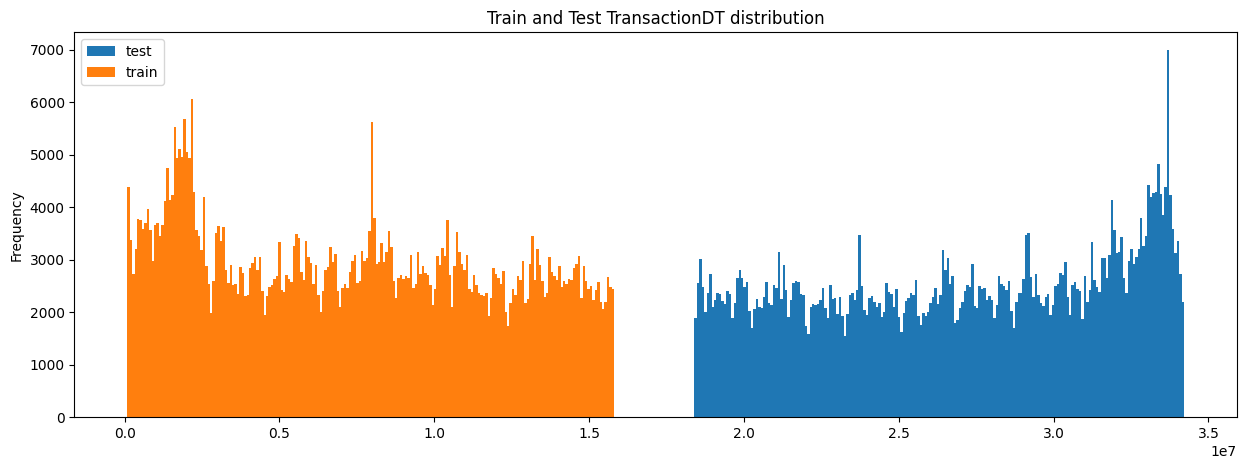

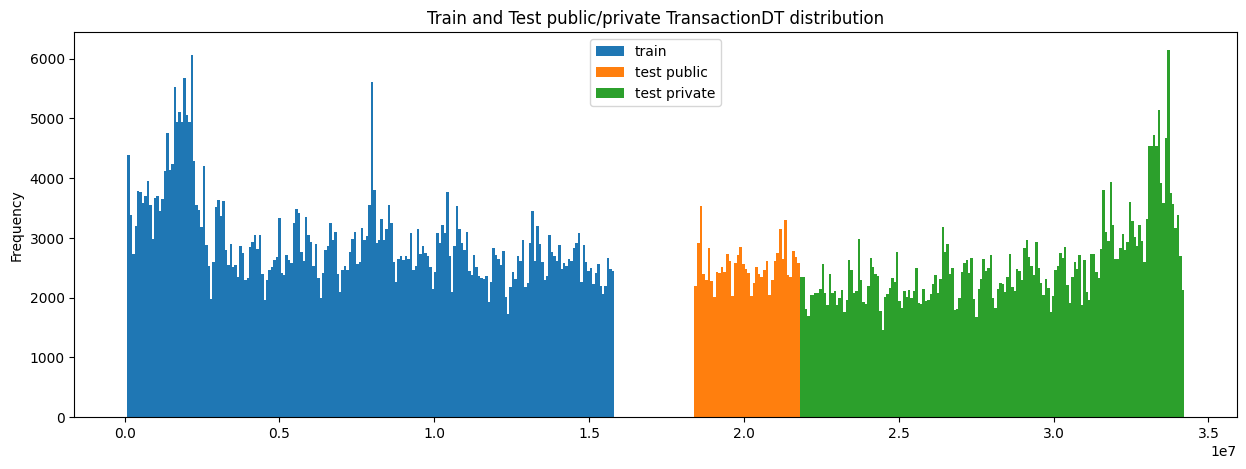

,Column,Correlation with TransactionDT
0,TransactionDT,1.000000
1,TransactionID,0.998280
2,V330,0.258603
3,V326,0.257295
4,V329,0.252599
5,V327,0.248494
375,V145,-0.252731
376,V160,-0.265566
377,V159,-0.279138
378,V151,-0.280576


In [14]:
COL = 'TransactionDT'
h('<h2 id="c_' + COL + '">' + COL + '</h2>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')

te['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='test', bins=200, title='Train and Test TransactionDT distribution')
tr['TransactionDT'].plot(kind='hist', label='train', bins=200)
plt.legend()
plt.show()

tr['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='train', bins=200, title='Train and Test public/private TransactionDT distribution')
n_public = int(te.shape[0] * 0.2)
te.loc[:n_public, 'TransactionDT'].plot(kind='hist', label='test public', bins=40)
te.loc[n_public:, 'TransactionDT'].plot(kind='hist', label='test private', bins=160)
plt.legend()
plt.show()

corr1(COL)

In [11]:
COL = 'isFraud'
h('<h2 id="c_' + COL + '">' + COL + '</h2>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
h('This is target column.')
trx = tr['isFraud'].value_counts().reset_index().rename({'index':'Value','isFraud':'Count'}, axis=1)
trx['Share'] = np.round(trx['Count'] / trx['Count'].sum(), 6)
display(trx)
corr1(COL)

,Value,Count,Share
0,0,569877,0.96501
1,1,20663,0.03499


,Column,Correlation with isFraud
0,isFraud,1.000000
1,V257,0.383060
2,V246,0.366878
3,V244,0.364129
4,V242,0.360590
5,V201,0.328005
375,V90,-0.110168
376,V49,-0.110920
377,V48,-0.115786
378,D7,-0.127199


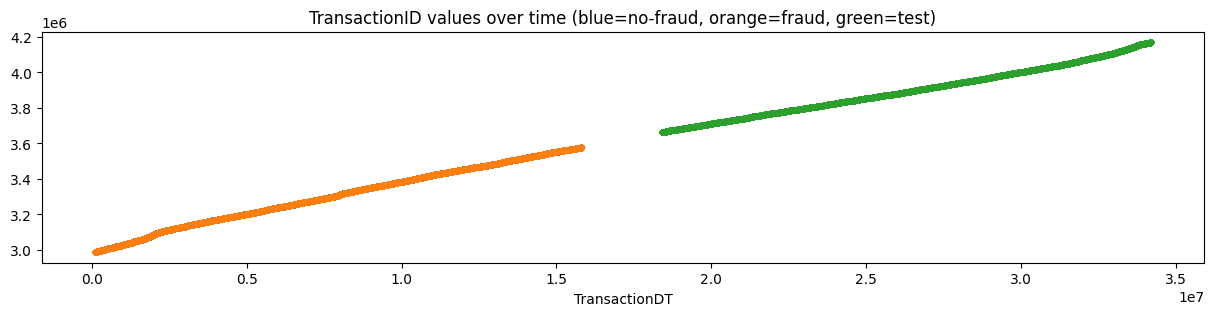

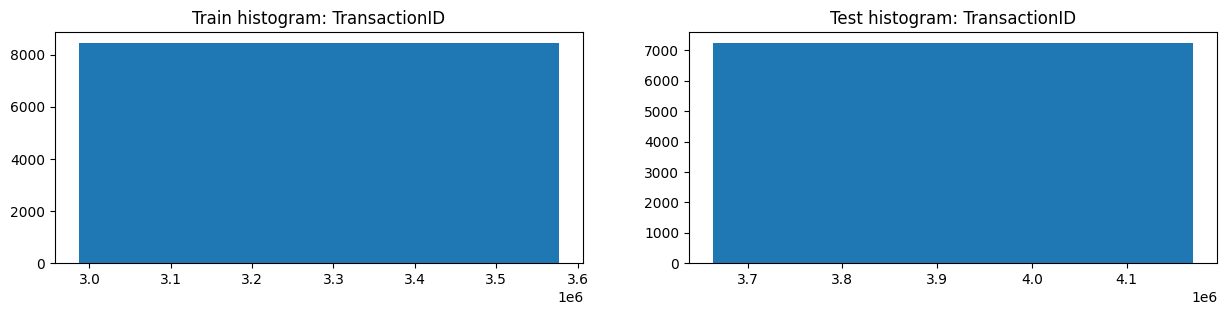

,TransactionID,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,5.905400e+05,2.066300e+04,5.698770e+05,5.066910e+05,1.013390e+05,4.053530e+05
1,mean,3.282270e+06,3.294952e+06,3.281810e+06,3.916894e+06,3.714218e+06,3.967563e+06
2,std,1.704744e+05,1.620403e+05,1.707548e+05,1.462692e+05,2.925419e+04,1.170155e+05
3,min,2.987000e+06,2.987203e+06,2.987000e+06,3.663549e+06,3.663549e+06,3.764887e+06
4,25%,3.134635e+06,3.167366e+06,3.133317e+06,3.790222e+06,3.688884e+06,3.866225e+06
5,50%,3.282270e+06,3.291934e+06,3.281808e+06,3.916894e+06,3.714218e+06,3.967563e+06
6,75%,3.429904e+06,3.428646e+06,3.429974e+06,4.043566e+06,3.739552e+06,4.068901e+06
7,max,3.577539e+06,3.577526e+06,3.577539e+06,4.170239e+06,3.764887e+06,4.170239e+06
8,unique values,5.905400e+05,2.066300e+04,5.698770e+05,5.066910e+05,1.013390e+05,4.053530e+05
9,NaNs,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


,Column,Correlation with TransactionID
0,TransactionID,1.000000
1,TransactionDT,0.998280
2,V326,0.251746
3,V330,0.250831
4,V329,0.244867
5,V327,0.242576
375,V145,-0.273548
376,V160,-0.282572
377,V159,-0.302742
378,V151,-0.303988


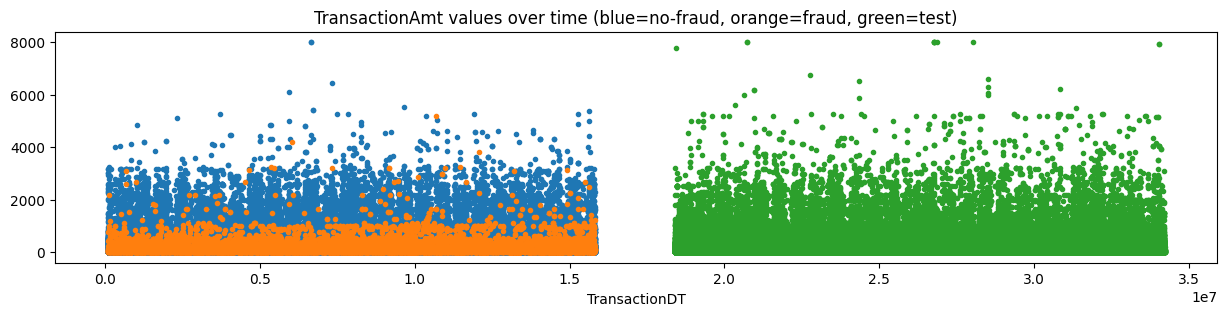

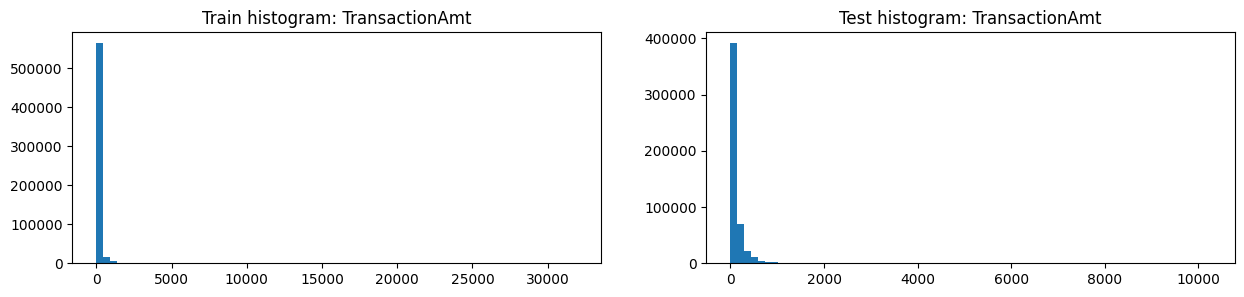

,TransactionAmt,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,590540.000000,20663.000000,569877.000000,506691.000000,101339.000000,405353.000000
1,mean,135.027176,149.244779,134.511665,134.725568,141.732271,132.973690
2,std,239.162522,232.212163,239.395078,245.779822,257.473804,242.736757
3,min,0.251000,0.292000,0.251000,0.018000,0.018000,0.140000
4,25%,43.321000,35.044000,43.970000,40.000000,45.950000,39.000000
5,50%,68.769000,75.000000,68.500000,67.950000,72.950000,67.950000
6,75%,125.000000,161.000000,120.000000,125.000000,134.950000,120.950000
7,max,31937.391000,5191.000000,31937.391000,10270.000000,9154.460000,10270.000000
8,unique values,20902.000000,2515.000000,20560.000000,14119.000000,5144.000000,12117.000000
9,NaNs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,TransactionAmt,Count in train (desc),Mean target,Sum target,Count in test
0,59.00,30582,0.021124,646,27365.0
1,117.00,28933,0.024851,719,25798.0
2,107.95,23954,0.009226,221,20243.0
3,57.95,23600,0.003814,90,20063.0
4,100.00,20362,0.025685,523,17565.0
5,50.00,17009,0.020754,353,14469.0
6,49.00,15990,0.029331,469,14231.0
7,226.00,11704,0.033322,390,11084.0
8,39.00,11095,0.021812,242,9926.0
9,29.00,10683,0.018815,201,9019.0


,TransactionAmt,Count in train,Mean target,Sum target (desc),Count in test
0,117.0,28933,0.024851,719,25798
1,59.0,30582,0.021124,646,27365
2,150.0,8356,0.067137,561,7426
3,100.0,20362,0.025685,523,17565
4,49.0,15990,0.029331,469,14231
5,200.0,6590,0.064188,423,6115
6,226.0,11704,0.033322,390,11084
7,300.0,2438,0.145611,355,2104
8,50.0,17009,0.020754,353,14469
9,171.0,7682,0.035407,272,7233


,Column,Correlation with TransactionAmt
0,TransactionAmt,1.000000
1,V139,0.222308
2,V140,0.207470
3,V208,0.198601
4,V161,0.197351
5,V163,0.191320
375,V15,-0.139413
376,V94,-0.141014
377,V52,-0.142297
378,V50,-0.144958


,ProductCD,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,590540,20663,569877,506691,101339,405353
1,unique,5,5,5,5,5,5
2,top,W,W,W,W,W,W
3,freq,439670,8969,430701,360987,82563,278425
4,unique values,5,5,5,5,5,5
5,NaNs,0,0,0,0,0,0
6,NaNs share,0.0,0.0,0.0,0.0,0.0,0.0


,ProductCD,Count in train (desc),Mean target,Sum target,Count in test
0,W,439670,0.020399,8969,360987
1,C,68519,0.116873,8008,69266
2,R,37699,0.037826,1426,35647
3,H,33024,0.047662,1574,29373
4,S,11628,0.058996,686,11418


,ProductCD,Count in train,Mean target,Sum target (desc),Count in test
0,W,439670,0.020399,8969,360987
1,C,68519,0.116873,8008,69266
2,H,33024,0.047662,1574,29373
3,R,37699,0.037826,1426,35647
4,S,11628,0.058996,686,11418


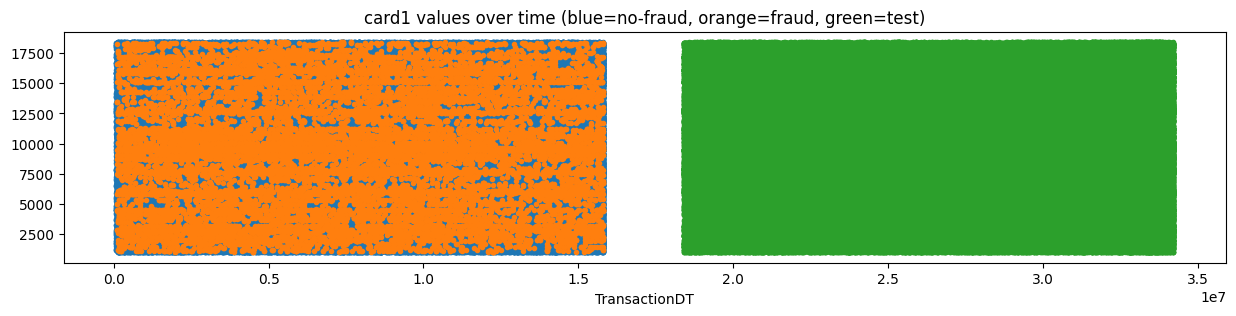

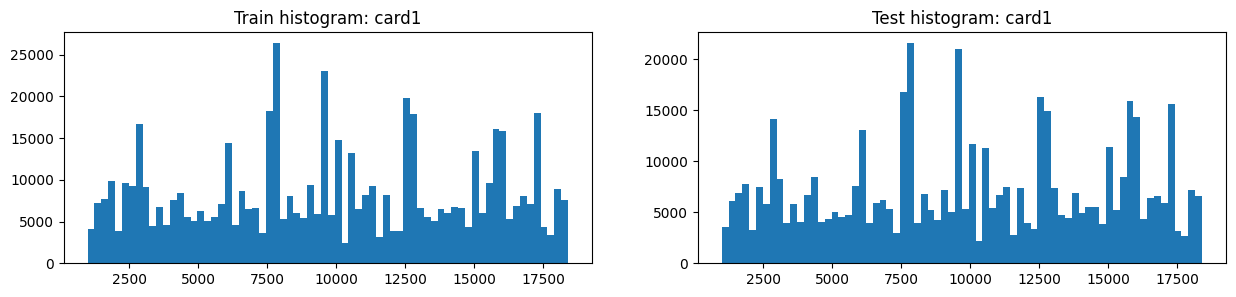

,card1,Train,Train fraud,Train Not fraud,Test,Test public,Test private
0,count,590540.000000,20663.000000,569877.000000,506691.000000,101339.000000,405353.000000
1,mean,9898.734658,9547.654164,9911.464381,9957.222175,9907.330406,9969.701591
2,std,4901.170153,4762.051380,4905.672370,4884.960969,4854.917514,4892.365179
3,min,1000.000000,1015.000000,1000.000000,1001.000000,1006.000000,1001.000000
4,25%,6019.000000,5732.500000,6019.000000,6019.000000,6053.000000,6019.000000
5,50%,9678.000000,9633.000000,9711.000000,9803.000000,9653.000000,9803.000000
6,75%,14184.000000,13623.000000,14229.000000,14276.000000,14052.000000,14290.000000
7,max,18396.000000,18375.000000,18396.000000,18397.000000,18396.000000,18397.000000
8,unique values,13553.000000,1740.000000,13350.000000,13244.000000,6935.000000,12300.000000
9,NaNs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,card1,Count in train (desc),Mean target,Sum target,Count in test
0,7919,14932,0.007501,112,13083.0
1,9500,14162,0.037283,528,12081.0
2,15885,10361,0.042853,444,12330.0
3,17188,10344,0.026875,278,9262.0
4,15066,7945,0.039396,313,6661.0
5,12695,7091,0.028346,201,5641.0
6,12544,6773,0.021556,146,5921.0
7,6019,6771,0.043420,294,6497.0
8,2803,6141,0.011887,73,4902.0
9,7585,5334,0.049306,263,4763.0


,card1,Count in train,Mean target,Sum target (desc),Count in test
0,9633,4158,0.178451,742,4751
1,9500,14162,0.037283,528,12081
2,15885,10361,0.042853,444,12330
3,9026,2076,0.191233,397,894
4,15063,2522,0.126487,319,2060
5,5812,2818,0.111427,314,3879
6,2616,4410,0.071202,314,1786
7,15066,7945,0.039396,313,6661
8,9917,919,0.332971,306,920
9,6019,6771,0.043420,294,6497


KeyboardInterrupt: 

In [12]:
for col in list(tr.columns.values[:COLS_TO_SHOW]):
    proc(col)